# Advanced Analysis of Movie Ratings and Recommendation System

In this notebook, we will conduct an in-depth analysis of user-provided movie ratings and implement several advanced methods:

1. Data loading and initial exploration (EDA)
2. Data cleaning and aggregation
3. Visualizations:
   - Rating distribution
   - Top movies by rating count and average rating
   - Genre analysis
   - Correlation heatmap
4. Advanced techniques:
   - Clustering movies based on genres
   - Simple recommendation engine using correlation
   - Recommendation using matrix factorization (SVD)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform 

# 1. Import libraries and load data

In [10]:
movies = pd.read_csv("movies.csv") 
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
ratings = pd.read_csv("ratings.csv")  
ratings.head() 

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [13]:
df = pd.merge(ratings, movies, on='movieId') # Merge ratings with movie details

## 2. Preliminary Analysis and Data Cleaning

In [14]:
df.head() 

,userId,movieId,rating,timestamp,title,genres
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama
1,1,1029,3.0,1260759179,Dumbo (1941),Animation|Children|Drama|Musical
2,1,1061,3.0,1260759182,Sleepers (1996),Thriller
3,1,1129,2.0,1260759185,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller
4,1,1172,4.0,1260759205,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
 4   title      100004 non-null  object 
 5   genres     100004 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


In [17]:
df.isnull().sum() # Check for missing values

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

In [46]:
df = df.drop_duplicates()
df.duplicated().sum() # Check for duplicated

np.int64(0)

## 3. Visual Exploratory Data Analysis (EDA)

In [20]:
# Visualization settings
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

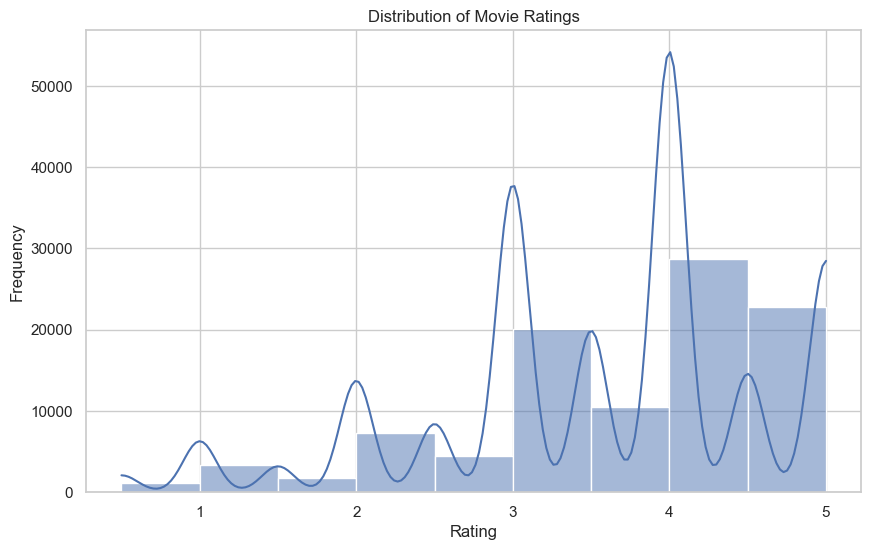

In [21]:
sns.histplot(df['rating'], bins=9, kde=True) 
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()  #Rating distribution

C:\Users\nurti\AppData\Local\Temp\ipykernel_11888\2880133583.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_by_count['rating_count'], y=top_by_count.index, palette='Blues')


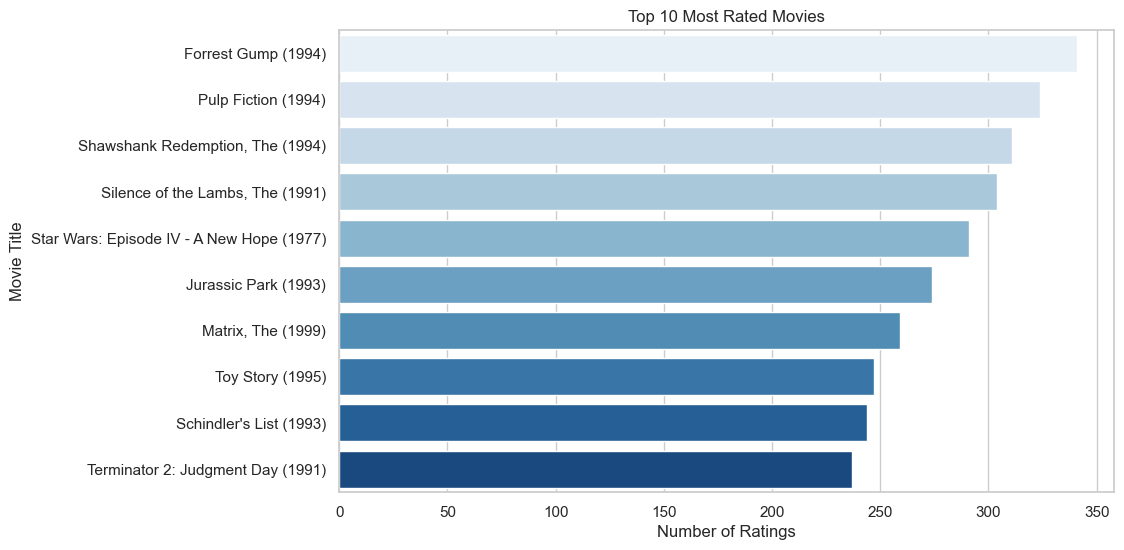

In [26]:
ratings_summary = df.groupby('title').agg({'rating': ['mean','count']})
ratings_summary.columns = ['avg_rating','rating_count']
ratings_summary = ratings_summary.sort_values('rating_count', ascending=False)
top_by_count = ratings_summary.head(10)
sns.barplot(x=top_by_count['rating_count'], y=top_by_count.index, palette='Blues')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show() # Top 10 movies by number of ratings

C:\Users\nurti\AppData\Local\Temp\ipykernel_11888\4290617611.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_by_avg['avg_rating'], y=top_by_avg.index, palette='Greens')


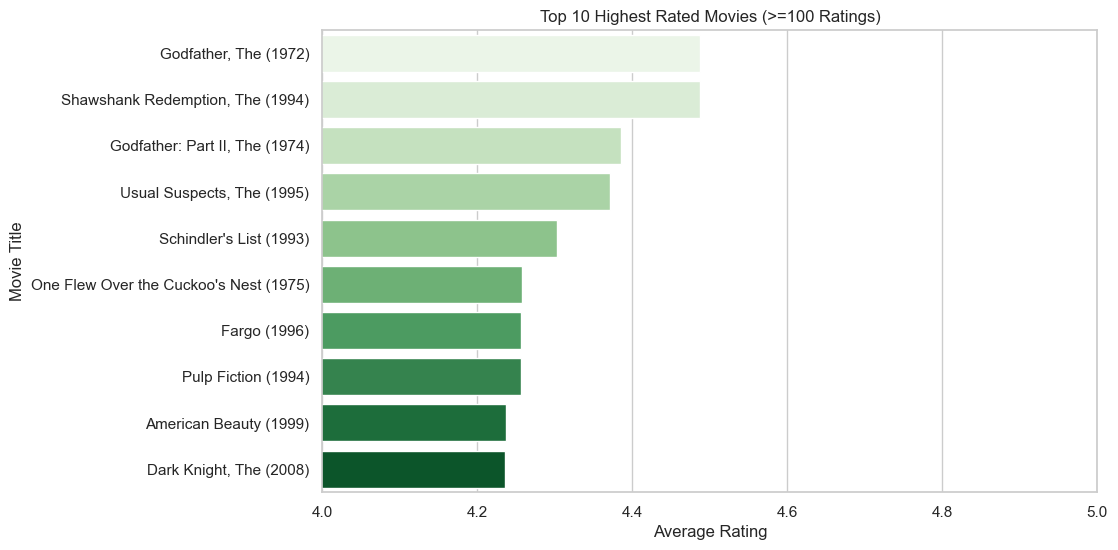

In [27]:
# Top 10 movies by average 'rating_count' min >100 ratings
top_by_avg = ratings_summary[ratings_summary['rating_count'] > 100]
top_by_avg = top_by_avg.sort_values('avg_rating', ascending=False).head(10)
sns.barplot(x=top_by_avg['avg_rating'], y=top_by_avg.index, palette='Greens')
plt.title('Top 10 Highest Rated Movies (>=100 Ratings)')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.xlim(4, 5)
plt.show()

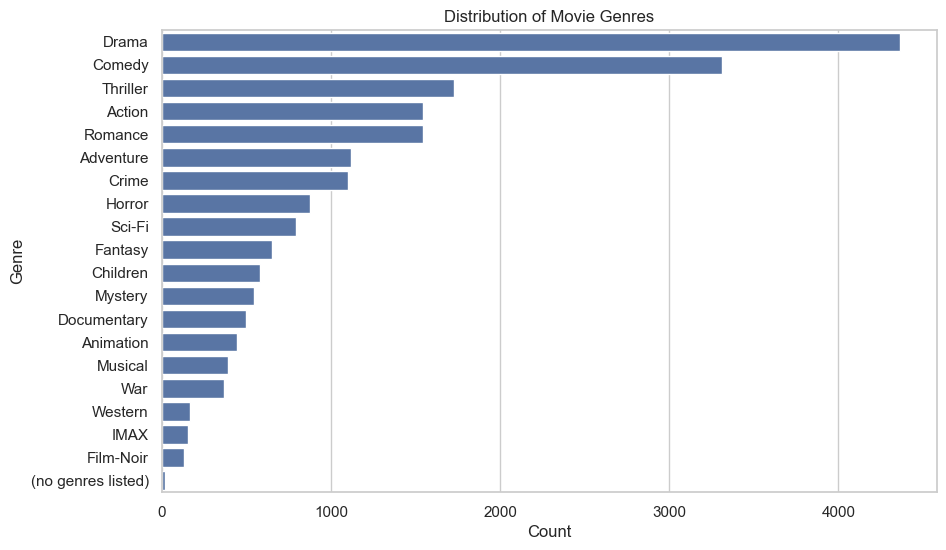

In [25]:
# Split genres and count frequency
genre_df = movies.copy()
genre_df['genres'] = genre_df['genres'].str.split('|')
genre_exploded = genre_df.explode('genres')
sns.countplot(y='genres', data=genre_exploded, order=genre_exploded['genres'].value_counts().index)
plt.title('Distribution of Movie Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

## 4. Techniques 
### 4.1 Clustering Movies by Genre

Build a binary movie-genre matrix and apply KMeans clustering to group similar movies.


In [28]:
# binary indicator matrix for genres
genre_matrix = pd.get_dummies(genre_exploded[['movieId','genres']], columns=['genres'])
genre_matrix = genre_matrix.groupby('movieId').sum()

In [29]:
# KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(genre_matrix)

In [30]:
# Attach cluster labels to movies
clustered_movies = movies[['movieId','title']].merge(
    pd.DataFrame({'cluster': clusters}, index=genre_matrix.index).reset_index(),
    on='movieId'
)

In [31]:
for cluster_id in range(3):
    print(f"Cluster {cluster_id} sample movies:")
    sample_titles = clustered_movies[clustered_movies['cluster'] == cluster_id]['title'].sample(5).values
    print(sample_titles, '\n')

Cluster 0 sample movies:
['Alaska: Spirit of the Wild (1997)'
 "Chuck Berry Hail! Hail! Rock 'n' Roll (1987)" 'Step Into Liquid (2002)'
 'Kurt Cobain About a Son (2006)' 'Home (2009)'] 

Cluster 1 sample movies:
['TMNT (Teenage Mutant Ninja Turtles) (2007)'
 'Million Dollar Duck, The (a.k.a. $1,000,000 Duck) (1971)'
 'Heavyweights (Heavy Weights) (1995)'
 "Darby O'Gill and the Little People (1959)" 'Cinderella (1997)'] 

Cluster 2 sample movies:
['Man and a Woman, A (Un homme et une femme) (1966)' 'Agora (2009)'
 'Walk the Line (2005)' 'Way We Were, The (1973)' 'Tequila Sunrise (1988)'] 



### 4.2 Simple Recommendation Engine Using Correlation

Pivot to a user-item matrix and compute movie-to-movie correlations to recommend similar movies

In [33]:
user_film_matrix = df.pivot_table(index='userId', columns='title', values='rating')

In [35]:
target_movie = 'Godfather, The (1972)'
corr_with_target = user_film_matrix.corrwith(user_film_matrix[target_movie])

c:\Users\nurti\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:2991: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\nurti\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\nurti\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\Users\nurti\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\nurti\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [36]:
# Build DataFrame of correlations
corr_df = pd.DataFrame({'correlation': corr_with_target, 'rating_count': ratings_summary['rating_count']})
corr_df = corr_df.dropna().sort_values('correlation', ascending=False)

In [37]:
print("Top movie recommendations based on correlation to The Godfather:")
print(corr_df[corr_df['rating_count'] >= 100].head(10))

Top movie recommendations based on correlation to The Godfather:
                                        correlation  rating_count
title                                                            
Godfather, The (1972)                      1.000000           200
Godfather: Part II, The (1974)             0.829814           135
Apocalypse Now (1979)                      0.485396           112
Amadeus (1984)                             0.483231           100
Casablanca (1942)                          0.458538           117
Goodfellas (1990)                          0.441279           131
Heat (1995)                                0.430635           104
One Flew Over the Cuckoo's Nest (1975)     0.403249           144
Jaws (1975)                                0.402116           108
Braveheart (1995)                          0.381971           228


### 4.3 Recommendation Engine Using Matrix Factorization (SVD)

In [39]:
matrix = user_film_matrix.fillna(0)
svd = TruncatedSVD(n_components=20, random_state=42)
latent_matrix = svd.fit_transform(matrix)

In [40]:
reconstructed_matrix = np.dot(latent_matrix, svd.components_)
reco_df = pd.DataFrame(reconstructed_matrix, index=matrix.index, columns=matrix.columns) # Reconstruct approximate ratings matrix

In [41]:
# Recommend top 10 movies for a specific user
user_id = 1
user_original_ratings = user_film_matrix.loc[user_id]
user_predictions = reco_df.loc[user_id]

In [42]:
unrated_movies = user_original_ratings[user_original_ratings.isna()].index
top_recommendations = user_predictions[unrated_movies].sort_values(ascending=False).head(10)

In [43]:
print("Top 10 movie recommendations for user 1 based on SVD:")
top_recommendations

Top 10 movie recommendations for user 1 based on SVD:


title
Alien (1979)                                                                   0.170681
Star Trek II: The Wrath of Khan (1982)                                         0.163507
Fantasia (1940)                                                                0.153250
Monty Python and the Holy Grail (1975)                                         0.148594
Lawrence of Arabia (1962)                                                      0.145153
Jaws (1975)                                                                    0.145069
African Queen, The (1951)                                                      0.140665
Monty Python's Life of Brian (1979)                                            0.139222
Great Escape, The (1963)                                                       0.134583
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)    0.134255
Name: 1, dtype: float64